# Clustering with K-Means  
This notebook details the process of grouping clusters using K-Means clustering. The unsupervised technique will cluster countries using year-on-year change in abatement over time. This is one component of testing methods of incorporating variance into the modeling process. The resulting clusters will be used to generate regression models. The theory behind this approach is that grouping the countries beforehand will result in models that are better able to learn variance because the groups are determined according to changes in value over time. This approach could be done with other measures, as well: 

 $$(xi-\mu)^2, \frac{(xi-\mu)^2}{\sqrt n}, or  \frac{x_t - x_{t-1}}{x_{t-1}}$$  
The notebook ends with a `.csv` file which is used in the [Variance Analysis notebook](https://github.com/sonyah-hawaii/time_series_regressive_modeling/blob/master/Variance%20Analysis.ipynb)

(Note: if you run all the cells the resulting clusters will persist but the labels may change, which will result in inconsistencies in the Variance Analysis notebook.)
## Notebook Contents
- [Reading in & preparing data](#reading_preparing)  
- [Determining Number of Clusters using `sklearn` functions](#elbow_curve)
- [Clustering `.diff()` values with `K-Means`](#clusters)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Reading In & Preparing Data
<a id='reading_preparing'></a>

In [2]:
abatement = pd.read_csv('./Data/abatement_calculations.csv')
gdp = pd.read_excel('./Data/Supplementary Datasets/gdp_pc.xlsx')
emissions = pd.read_csv('./Data/CO2_emissions.csv')

In [3]:
emissions.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1, inplace=True)
abatement.set_index('country', inplace=True)
emissions.set_index('Country', inplace=True)

In [4]:
abatement_yoy_change = abatement.T.diff()

In [7]:
# abatement_yoy_change.drop('1990', axis=0, inplace=True)
# gdp.drop(['1990', '2015', '2016', '2017'], inplace=True)

In [8]:
gdp.isnull().sum().sum()

659

In [9]:
gdp.fillna(0, inplace=True)

In [10]:
# clusters = pd.merge(abatement_yoy_change.T, gdp, how='inner',
#                     left_index=True, right_index=True,
#                    suffixes=['_abatement','_gdp_pc'])
clusters = abatement_yoy_change.T.drop('label', axis=1).drop('World', axis=0)

#Added this in after I had already run this entire notebook, because label was already on my dataframe
label = abatement_yoy_change.T['label'].drop('World', axis=0)

In [11]:
# clusters.to_csv('./Data/clustered_data.csv')

In [12]:
clusters.shape

(37, 24)

In [14]:
clusters.head()

,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
country,,,,,,,,,,,,,,,,,,,,,
Algeria,0.221591,-0.144035,0.193535,-0.257759,0.049240,-0.092277,-0.072547,0.164976,-0.010782,-0.187619,...,0.307247,-0.355223,-0.006837,0.042006,0.049848,-0.159937,0.246612,0.095462,-0.243023,-0.099268
Argentina,-2.514651,4.366813,0.885648,2.289184,-1.163970,-4.532136,5.207687,-2.070757,-5.869402,6.050696,...,2.472290,5.934784,-6.065012,-2.141209,3.517871,0.731120,6.479120,-2.251763,2.021943,2.164555
Australia,1.556081,-0.561085,1.067321,-0.742895,-0.534435,0.393304,1.492848,-0.665100,0.671673,-0.189580,...,2.728832,1.854505,-1.097874,-1.858742,-1.180898,2.833040,4.757738,0.353944,6.662100,3.615704
Belgium,0.043625,0.054352,-0.053460,0.105818,0.039514,-0.036604,-0.038866,0.117332,-0.031643,0.138529,...,0.238382,0.331535,0.147817,0.319802,0.063341,0.534419,0.562500,1.111464,0.138684,0.766849
Brazil,9.756433,11.309725,107.584207,18.490205,-123.463794,-15.848677,8.902263,7.649689,-102.370462,6.281242,...,54.779431,-10.346208,42.658298,-63.378976,102.368606,-86.464801,45.821475,-46.291123,-32.700359,-9.130219


## Determining Clusters
_Using Inertia, Silhouette to generate an elbow curve_
<a id='elbow_curve'></a>

In [15]:
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [16]:
clusters.min().min()

-2431.1279142858275

In [17]:
clusters.max().max()

2315.4511999998404

In [18]:
clusters.isnull().sum().sum()

0

In [19]:
n = range(2,15, 1)

kmeans_inertia = []
kmeans_silhouette = []
for i in n:
    km = KMeans(n_clusters=i, random_state=1994)
    km.fit(clusters)
    predictions = km.predict(clusters)
    kmeans_inertia.append(km.inertia_)
    kmeans_silhouette.append(silhouette_score(clusters, predictions))

kmeans_silhouette = minmax_scale(kmeans_silhouette)
kmeans_inertia = minmax_scale(kmeans_inertia)

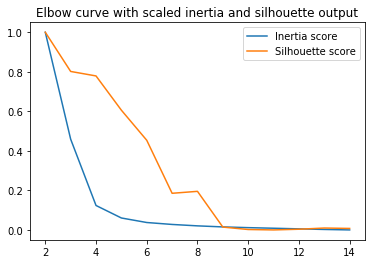

In [20]:
plt.plot(n, kmeans_inertia, label='Inertia score');
plt.plot(n, kmeans_silhouette, label='Silhouette score');
plt.legend();
plt.title('Elbow curve with scaled inertia and silhouette output');

#### _While this graph says that the optimal clusters would be 3-4, I'm actually going to steer away from that and use 6. While achieving maximum Silhouette score can be significant for certain applications of K-Means, like profile development (where clusters guide you towards revealing patterns in exogenous features), in this case it is most important that it facilitates grouping according to trend. In this case, minimizing distance within groups is not as important as maximizing between._

## Clustering with `K-Means`
We're going to use the number of clusters according to the elbow curve. The value looks halfway between 3 and 4, but 4 turned out a little better so we'll work with that._
<a id='reading_preparing'></a>

In [21]:
clusters = clusters.iloc[:, 0:24]

In [24]:
ss = StandardScaler()
clusters_scaled = ss.fit_transform(clusters)

km = KMeans(n_clusters = 6, random_state=1994)
km.fit(clusters_scaled)


centers = km.cluster_centers_
centers = pd.DataFrame(centers)
clusters['label'] = km.labels_

for i in range(0, 6):
    print(f'There are {len(clusters[clusters.label==i])} countries in cluster {i}')
    print(f'{[n for n in clusters[clusters.label==i].index]}\n')

There are 1 countries in cluster 0
['United States']

There are 28 countries in cluster 1
['Algeria', 'Argentina', 'Australia', 'Belgium', 'Chile', 'France', 'Indonesia', 'Italy', 'Kazakhstan', 'Kuwait', 'Malaysia', 'Mexico', 'Netherlands', 'New Zealand', 'Nigeria', 'Poland', 'Portugal', 'Romania', 'Saudi Arabia', 'South Africa', 'Spain', 'Sweden', 'Thailand', 'Turkey', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'Uzbekistan']

There are 1 countries in cluster 2
['Norway']

There are 1 countries in cluster 3
['China']

There are 1 countries in cluster 4
['Brazil']

There are 5 countries in cluster 5
['Canada', 'Colombia', 'Germany', 'India', 'Japan']



In [27]:
#Code used to save labels during the first run through
labels = [i for i in km.labels_]
#NaN added for World value
labels.append(np.nan)

#Saved to dataframe
abatement['label']=labels
emissions['label'] = labels

In [28]:
#Saving all output to csv's
clusters.to_csv('./Data/clusters_abatement.csv')
emissions.to_csv('./Data/clusters_emissions.csv')
centers.to_csv('./Data/cluster_centers.csv')
abatement.to_csv('./Data/abatement_calculations.csv')

For a more in-depth analysis of variance of each cluster see the [Variance Analysis](#www.google.com) notebook